# Functional Neural Network with Adaptive Bases

In this notewboook, we present a PyTorch implementation of the model proposed in "Deep Learning for Functional Data Analysis with Adaptive Basis Layers", ICML 2021.

Unlike many functional networks, AdaFNNs take the raw functional data as input and learn to apply parsimonious dimension reduction that focuses only on information relevant to the target rather than irrelevant variation in the input. This operation is done through a novel _Basis Layer_ that consists of _basis nodes_ implemented as micro networks. In addition, the inference and training can be done in an end-to-end manner without preprocessing the data.

# Implementing AdaFNNs

First, we provide the code for two building blocks, a layer normalization module and feedforward network module (with skipping connection). We start by import the necessary packages.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### Layer Normalization

The layer normalization was introduced in [Layer Normalization](https://arxiv.org/abs/1607.06450). It is a transposition of Batch Normalization.

In [2]:
class LayerNorm(nn.Module):

    def __init__(self, d, eps=1e-6):
        super().__init__()
        # d is the normalization dimension
        self.d = d
        self.eps = eps
        self.alpha = nn.Parameter(torch.randn(d))
        self.beta = nn.Parameter(torch.randn(d))

    def forward(self, x):
        # x is a torch.Tensor
        # avg is the mean value of a layer
        avg = x.mean(dim=-1, keepdim=True)
        # std is the standard deviation of a layer (eps is added to prevent dividing by zero)
        std = x.std(dim=-1, keepdim=True) + self.eps
        return (x - avg) / std * self.alpha + self.beta

Next, we implement a feedforward network module.

In [3]:
class FeedForward(nn.Module):

    def __init__(self, in_d=1, hidden=[4,4,4], dropout=0.1, activation=F.relu):
        # in_d      : input dimension, integer
        # hidden    : hidden layer dimension, array of integers
        # dropout   : dropout probability, a float between 0.0 and 1.0
        # activation: activation function at each layer
        super().__init__()
        self.sigma = activation
        dim = [in_d] + hidden + [1]
        self.layers = nn.ModuleList([nn.Linear(dim[i-1], dim[i]) for i in range(1, len(dim))])
        self.ln = nn.ModuleList([LayerNorm(k) for k in hidden])
        self.dp = nn.ModuleList([nn.Dropout(dropout) for _ in range(len(hidden))])

    def forward(self, t):
        for i in range(len(self.layers)-1):
            t = self.layers[i](t)
            # skipping connection
            t = t + self.ln[i](t)
            t = self.sigma(t)
            # apply dropout
            t = self.dp[i](t)
        # linear activation at the last layer
        return self.layers[-1](t)

### Metric operations

To build an AdaFNN, we need three new operations: (1) $\langle f_1, f_2 \rangle$ (2) $\| f \|_2$ and (3) $\| f \|_1$. The last two can be established on the first one through:

$$ \| f\|_2 = \sqrt{ \langle f, f \rangle} $$
and
$$ \| f\|_1 = \langle 1, |f| \rangle .$$

Since the input is densely observed (equal spacing is not required), the inner product can be approximated by any numerical integration scheme. Here, we will use the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule).

In [4]:
def _inner_product(f1, f2, h):
    """
    f1 - (B, J) : B functions, observed at J time points,
    f2 - (B, J) : same as f1
    h  - (J-1,1): weights used in the trapezoidal rule
    pay attention to dimension
    <f1, f2> = sum (h/2) (f1(t{j}) + f2(t{j+1}))
    """
    prod = f1 * f2 # (B, J = len(h) + 1)
    return torch.matmul((prod[:, :-1] + prod[:, 1:]), h.unsqueeze(dim=-1))/2

Then $L_1$ and $L_2$ can be easily implememnted as:

In [5]:
def _l1(f, h):
    # f dimension : ( B bases, J )
    B, J = f.size()
    return _inner_product(torch.abs(f), torch.ones((B, J)), h)

In [6]:
def _l2(f, h):
    # f dimension : ( B bases, J )
    # output dimension - ( B bases, 1 )
    return torch.sqrt(_inner_product(f, f, h))

### AdaFNN

To prevent the original scale of basis nodes from dominating regularizers, they are normalized.

With these in hand, we are ready to present the AdaFNN implmentation.

In [7]:
class AdaFNN(nn.Module):

    def __init__(self, n_base=4, base_hidden=[64, 64, 64], grid=(0, 1),
                 sub_hidden=[128, 128, 128], dropout=0.1, lambda1=0.0, lambda2=0.0,
                 device=None):
        """
        n_base      : number of basis nodes, integer
        base_hidden : hidden layers used in each basis node, array of integers
        grid        : observation time grid, array of sorted floats including 0.0 and 1.0
        sub_hidden  : hidden layers in the subsequent network, array of integers
        dropout     : dropout probability
        lambda1     : penalty of L1 regularization, a positive real number
        lambda2     : penalty of L2 regularization, a positive real number
        device      : device for the training
        """
        super().__init__()
        self.n_base = n_base
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.device = device
        # grid should include both end points
        grid = np.array(grid)
        # send the time grid tensor to device
        self.t = torch.tensor(grid).to(device).float()
        self.h = torch.tensor(grid[1:] - grid[:-1]).to(device).float()
        # instantiate each basis node in the basis layer
        self.BL = nn.ModuleList([FeedForward(1, hidden=base_hidden, dropout=dropout, activation=F.selu)
                                 for _ in range(n_base)])
        # instantiate the subsequent network
        self.FF = FeedForward(n_base, sub_hidden, dropout)

    def forward(self, x):
        B, J = x.size()
        assert J == self.h.size()[0] + 1
        T = self.t.unsqueeze(dim=-1)
        # evaluate the current basis nodes at time grid
        self.bases = [basis(T).transpose(-1, -2) for basis in self.BL]
        """
        compute each basis node's L2 norm
        normalize basis nodes
        """
        l2_norm = _l2(torch.cat(self.bases, dim=0), self.h).detach()
        self.normalized_bases = [self.bases[i] / (l2_norm[i, 0] + 1e-6) for i in range(self.n_base)]
        # compute each score <basis_i, f>
        score = torch.cat([_inner_product(b.repeat((B, 1)), x, self.h) # (B, 1)
                           for b in self.bases], dim=-1) # score dim = (B, n_base)
        # take the tensor of scores into the subsequent network
        out = self.FF(score)
        return out

    def R1(self, l1_k):
        """
        L1 regularization
        l1_k : number of basis nodes to regularize, integer
        """
        if self.lambda1 == 0: return torch.zeros(1).to(self.device)
        # sample l1_k basis nodes to regularize
        selected = np.random.choice(self.n_base, min(l1_k, self.n_base), replace=False)
        selected_bases = torch.cat([self.normalized_bases[i] for i in selected], dim=0) # (k, J)
        return self.lambda1 * torch.mean(_l1(selected_bases, self.h))

    def R2(self, l2_pairs):
        """
        L2 regularization
        l2_pairs : number of pairs to regularize, integer
        """
        if self.lambda2 == 0 or self.n_base == 1: return torch.zeros(1).to(self.device)
        k = min(l2_pairs, self.n_base * (self.n_base - 1) // 2)
        f1, f2 = [None] * k, [None] * k
        for i in range(k):
            a, b = np.random.choice(self.n_base, 2, replace=False)
            f1[i], f2[i] = self.normalized_bases[a], self.normalized_bases[b]
        return self.lambda2 * torch.mean(torch.abs(_inner_product(torch.cat(f1, dim=0),
                                                                  torch.cat(f2, dim=0),
                                                                  self.h)))

#  Data

First, we import necessary dependencies.

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path

Next, we list configurations for each cases and implememnt functions for generating $X$ and $y$.

In [9]:
z1 = [20, 5, 5] + [1] * 47
z2 = [1] * 50
z2[0] = z2[2] = 5
z2[4] = z2[9] = 3
Z = [z1, z2, z2, [1] * 50]


def _phi(k):
    if k == 1: return lambda t: np.ones((len(t),))
    return lambda t : np.sqrt(2) * np.cos((k-1) * np.pi * t)


def _b1(t):
    return (4 - 16 * t) * (0 <= t) * (t <= 1/4)


def _b2(t):
    return (4 - 16 * np.abs(1/2 - t)) * (1/4 <= t) * (t <= 3/4)

In [10]:
X1 = pd.read_csv("data_windowedtrainETH.csv", header=None)



In [11]:
X2 = pd.read_csv("data_windowedtestETH.csv", header=None)



In [12]:
X2

,0,1,2,3,4,5,6,7
0,1657.059204,1696.457031,1507.782837,1491.395020,1430.547363,1553.037354,1523.838867,1553.684937
1,1696.457031,1507.782837,1491.395020,1430.547363,1553.037354,1523.838867,1553.684937,1586.176758
2,1507.782837,1491.395020,1430.547363,1553.037354,1523.838867,1553.684937,1586.176758,1577.220459
3,1491.395020,1430.547363,1553.037354,1523.838867,1553.684937,1586.176758,1577.220459,1556.872681
4,1430.547363,1553.037354,1523.838867,1553.684937,1586.176758,1577.220459,1556.872681,1577.641602
...,...,...,...,...,...,...,...,...
433,1816.458984,1847.089722,1800.620972,1832.795166,1857.698608,1894.157715,1899.837402,1888.124268
434,1847.089722,1800.620972,1832.795166,1857.698608,1894.157715,1899.837402,1888.124268,1889.322388
435,1800.620972,1832.795166,1857.698608,1894.157715,1899.837402,1888.124268,1889.322388,2120.561035
436,1832.795166,1857.698608,1894.157715,1899.837402,1888.124268,1889.322388,2120.561035,2078.289795


In [13]:
X1

,0,1,2,3,4,5,6,7
0,320.884003,299.252991,314.681000,307.907990,316.716003,337.631012,333.356995,330.924011
1,299.252991,314.681000,307.907990,316.716003,337.631012,333.356995,330.924011,332.394012
2,314.681000,307.907990,316.716003,337.631012,333.356995,330.924011,332.394012,347.612000
3,307.907990,316.716003,337.631012,333.356995,330.924011,332.394012,347.612000,354.385986
4,316.716003,337.631012,333.356995,330.924011,332.394012,347.612000,354.385986,366.730011
...,...,...,...,...,...,...,...,...
1744,1612.987305,1577.003784,1619.318970,1622.505859,1662.769897,1657.059204,1696.457031,1507.782837
1745,1577.003784,1619.318970,1622.505859,1662.769897,1657.059204,1696.457031,1507.782837,1491.395020
1746,1619.318970,1622.505859,1662.769897,1657.059204,1696.457031,1507.782837,1491.395020,1430.547363
1747,1622.505859,1662.769897,1657.059204,1696.457031,1507.782837,1491.395020,1430.547363,1553.037354


In [14]:
Y1 = pd.read_csv("targettrainETH.csv", header=None)

In [15]:
Y2 = pd.read_csv("targettestETH.csv", header=None)

In [16]:
Y1

,0
0,332.394012
1,347.612000
2,354.385986
3,366.730011
4,360.401001
...,...
1744,1491.395020
1745,1430.547363
1746,1553.037354
1747,1523.838867


In [17]:
Y2

,0
0,1586.176758
1,1577.220459
2,1556.872681
3,1577.641602
4,1617.183228
...,...
433,1889.322388
434,2120.561035
435,2078.289795
436,2052.713867


In [18]:
T1 = pd.read_csv("numbersw.csv", header=None)

In [19]:
T1

,0,1,2,3,4,5,6,7
0,0.0,0.142857,0.285714,0.428571,0.571429,0.714286,0.857143,1.0


The time grid doesn't have to be equally spaced. The model works as long as the time gap is small enough for numerical integration to work well.

In [20]:
def random_grid(d=0.02):
    """
    d : maximum time gap between two consecutive time points, float
    """
    grid = [0.0]
    while 1.0 - grid[-1] > d:
        grid.append(grid[-1] + np.random.uniform(0, d, 1).item())
    return grid + [1.0]

### Data Loader

This module reads the dataset from csv files and split it according to a pre-specific train/valid/test ratio. The dataset is standardized.

In [21]:
from sklearn.preprocessing import StandardScaler

class DataLoader1:

    def __init__(self, batch_size, X, Y, T, split=(8, 1, 1) ,random_seed=10294):
        """
        batch_size : batch size, integer
        X - (n, J) : pandas.DataFrame for observed functional data, n - subject number, J - number of time points
        Y - (n, 1) : pandas.DataFrame for response
        split      : train/valid/test split
        random_seed: random seed for training data re-shuffle
        """
        self.n, J = X.shape
        self.t = T.iloc[0, :].to_numpy()
        X, Y = X.values, Y.values

        # train/valid/test split
        self.batch_size = batch_size
        train_n = self.n // sum(split) * split[0]
        valid_n = self.n // sum(split) * split[1]
        
        X2 = pd.read_csv("data_windowedtestETH.csv", header=None)
        Y2 = pd.read_csv("targettestETH.csv", header=None)


        
        self.n1, J = X2.shape

        self.t = T.iloc[0, :].to_numpy()
        X2, Y2 = X2.values, Y2.values
        
        test_n = self.n1 // sum(split) * 10
        
        self.train_B = train_n // batch_size
        #self.valid_B = valid_n // batch_size
        self.test_B = test_n // 5

        

        # standardize dataset based on the training dataset
        self.X_standardizer = StandardScaler()
        #self.Y_standardizer = StandardScaler()

        # train/valid/test split
        #self.train_X = X[:(self.train_B * self.batch_size), :]
        #self.train_Y = Y[:(self.train_B * self.batch_size), :]
        self.train_X = X
        self.train_Y = Y
        #self.X_standardizer.fit(self.train_X)
        #self.Y_standardizer.fit(self.train_Y)
        #self.train_X = self.X_standardizer.transform(self.train_X)
        #self.train_Y = self.Y_standardizer.transform(self.train_Y)

        #self.valid_X = X[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        #self.valid_Y = Y[(self.train_B * self.batch_size):((self.train_B + self.valid_B) * self.batch_size), :]
        #self.valid_X = self.X_standardizer.transform(self.valid_X)
        #self.valid_Y = self.Y_standardizer.transform(self.valid_Y)

        self.test_X = X2
        self.test_Y = Y2
        #self.test_X = self.X_standardizer.transform(self.test_X)
        #self.test_Y = self.Y_standardizer.transform(self.test_Y)

        
    def shuffle(self):
        # re-shuffle the training dataset
        train_size = self.train_X.shape[0]
        new_order = list(range(train_size))
        np.random.shuffle(new_order)
        self.train_X = self.train_X[new_order, :]
        self.train_Y = self.train_Y[new_order, :]        
        

    def _batch_generator(self, X, Y, N):

        def generator_func():
            for i in range(1, N):
                x = X[((i - 1) * self.batch_size):((i) * self.batch_size), :]
                y = Y[((i - 1) * self.batch_size):((i) * self.batch_size), :]

                yield torch.Tensor(x), torch.Tensor(y)

        return generator_func()
    def _batch_generator1(self, X, Y, N):

        def generator_func():
            x = X
            y = Y
            yield torch.Tensor(x), torch.Tensor(y)

        return generator_func()
    
    def get_train_batch(self):
        return self._batch_generator(self.train_X, self.train_Y, self.train_B)

    #def get_valid_batch(self):
        #return self._batch_generator(self.valid_X, self.valid_Y, self.valid_B)

    def get_test_batch(self):
        return self._batch_generator1(self.test_X, self.test_Y, self.test_B)

# Training the model

First, we load necessary packages.

In [22]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.optim import Adam

A dataset will be generated if it is not present.

Here, we set the measurement error variance to be 1 and noise variance to be 0.2.

**Note**: in this example, we use a flexible time point gap (**not** equal spacing).

The dataset is loaded and split for training/validation/test.

In [23]:
batch_size = 400
split = (10, 0, 0)

In [24]:
grid = T1.iloc[0, :].to_list()
dataLoader = DataLoader1(batch_size,  X1, Y1, T1, split)

Prepare the model and other training configurations:

In [25]:
# set up CPU/GPU
device = torch.device("cpu")
# model configuration
"""
You can use a different model by modifing base_hidden, sub_hidden, n_base.
"""
base_hidden = [256,256,256,256]
sub_hidden = [1024,512,256,128]
n_base = 12
lambda1, l1_k = 0.0, 2
lambda2, l2_pairs = 0.0, 3
dropout = 0.1
save_model_every = 100
model = AdaFNN(n_base=n_base,
               base_hidden=base_hidden,
               grid=grid,
               sub_hidden=sub_hidden,
               dropout=dropout,
               lambda1=lambda1,
               lambda2=lambda2,
               device=device)
# send model to CPU/GPU
_ = model.to(device)

In [26]:
# training configuration
epoch = 15000
pred_loss_train_history = []
total_loss_train_history = []
loss_valid_history = []
# instantiate an optimizer
optimizer = Adam(model.parameters(), lr=3e-4)
# use MSE loss
compute_loss = torch.nn.MSELoss()
min_valid_loss = sys.maxsize

Create a folder to save checkpoints.

In [27]:
folder = "train/"
Path(folder).mkdir(parents=True, exist_ok=True)

Save and load models:

In [28]:
def save_model(folder, k, n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer):
    checkpoint = {'n_base': n_base,
                  'base_hidden': base_hidden,
                  'grid': grid,
                  'sub_hidden': sub_hidden,
                  'dropout': dropout,
                  'lambda1' : lambda1,
                  'lambda2' : lambda2,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, folder + str(k) + '_' + 'checkpoint.pth')


def load_model(file_path, device):
    checkpoint = torch.load(file_path)
    model = AdaFNN(n_base=checkpoint['n_base'],
                   base_hidden=checkpoint['base_hidden'],
                   grid=checkpoint['grid'],
                   sub_hidden=checkpoint['sub_hidden'],
                   dropout=checkpoint['dropout'],
                   lambda1=checkpoint['lambda1'],
                   lambda2=checkpoint['lambda2'],
                   device=device)
    model.load_state_dict(checkpoint['state_dict'])
    _ = model.to(device)
    return model, checkpoint['grid']

Training procedure:

In [29]:
import math
for k in range(epoch):

    if k and k % save_model_every == 0:
        save_model(folder, k, n_base, base_hidden, grid, sub_hidden, dropout, lambda1, lambda2, model, optimizer)

    pred_loss_train = []
    total_loss_train = []
    loss_valid = []
    dataLoader.shuffle()
    # set model training state
    model.train()

    for i, (x, y) in enumerate(dataLoader.get_train_batch()):
        x, y = x.to(device), y.to(device)
        out = model.forward(x)
        loss_pred = compute_loss(out, y)
        #loss = loss_pred + model.R1(l1_k) + model.R2(l2_pairs)
        loss = loss_pred 
        # record training loss history
        total_loss_train.append(loss.item())
        pred_loss_train.append(loss_pred.item())

        # update parameters using backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss_train_history.append(math.sqrt(np.mean(total_loss_train)))
    pred_loss_train_history.append(math.sqrt(np.mean(pred_loss_train)))



    if (k+1) % 50 == 0:
        print("epoch:", k+1, "\n",
              "prediction training loss = ", pred_loss_train_history[-1],
              )
        

epoch: 50 
 prediction training loss =  205.530389201735
epoch: 100 
 prediction training loss =  199.34614145897916
epoch: 150 
 prediction training loss =  191.36016537049971
epoch: 200 
 prediction training loss =  236.4519226370342
epoch: 250 
 prediction training loss =  194.28211540073198
epoch: 300 
 prediction training loss =  183.7738115240671
epoch: 350 
 prediction training loss =  201.4131875906259
epoch: 400 
 prediction training loss =  199.64872797825018
epoch: 450 
 prediction training loss =  160.18799177320793
epoch: 500 
 prediction training loss =  209.75396984224955
epoch: 550 
 prediction training loss =  165.30066710958852
epoch: 600 
 prediction training loss =  164.89222529743986
epoch: 650 
 prediction training loss =  160.32610403616957
epoch: 700 
 prediction training loss =  153.49546596859682
epoch: 750 
 prediction training loss =  184.696289624458
epoch: 800 
 prediction training loss =  160.20516224646653
epoch: 850 
 prediction training loss =  162.219

epoch: 6850 
 prediction training loss =  142.74312798148114
epoch: 6900 
 prediction training loss =  138.1068309128541
epoch: 6950 
 prediction training loss =  147.76287155756518
epoch: 7000 
 prediction training loss =  120.43108063241675
epoch: 7050 
 prediction training loss =  124.84291692462973
epoch: 7100 
 prediction training loss =  127.74962033130144
epoch: 7150 
 prediction training loss =  137.36495972939508
epoch: 7200 
 prediction training loss =  125.47072824301823
epoch: 7250 
 prediction training loss =  131.01092437154813
epoch: 7300 
 prediction training loss =  136.22517095060235
epoch: 7400 
 prediction training loss =  143.10227030213392
epoch: 7450 
 prediction training loss =  124.00006431659959
epoch: 7500 
 prediction training loss =  138.26661174874855
epoch: 7550 
 prediction training loss =  126.02353993277407
epoch: 7600 
 prediction training loss =  126.9828333829354
epoch: 7650 
 prediction training loss =  137.96641301342754
epoch: 7700 
 prediction t

epoch: 13750 
 prediction training loss =  120.8959553965723
epoch: 13800 
 prediction training loss =  120.28832414028872
epoch: 13850 
 prediction training loss =  134.59683723531546
epoch: 13900 
 prediction training loss =  143.1124812574594
epoch: 13950 
 prediction training loss =  113.84420606780274
epoch: 14000 
 prediction training loss =  128.95007714551136
epoch: 14050 
 prediction training loss =  128.98764854265116
epoch: 14100 
 prediction training loss =  130.9289476124996
epoch: 14150 
 prediction training loss =  109.54971016573177
epoch: 14200 
 prediction training loss =  128.79507706042185
epoch: 14250 
 prediction training loss =  122.85463256299089
epoch: 14300 
 prediction training loss =  122.06334005087277
epoch: 14350 
 prediction training loss =  129.85230116246495
epoch: 14400 
 prediction training loss =  119.59188549195483
epoch: 14450 
 prediction training loss =  142.59207323325631
epoch: 14500 
 prediction training loss =  134.09704780183145
epoch: 1455

Please note that the validation error was computed after a training epoch was complete. So the validation error is generally smaller than the training error.

Make a loss plot after training finishes.

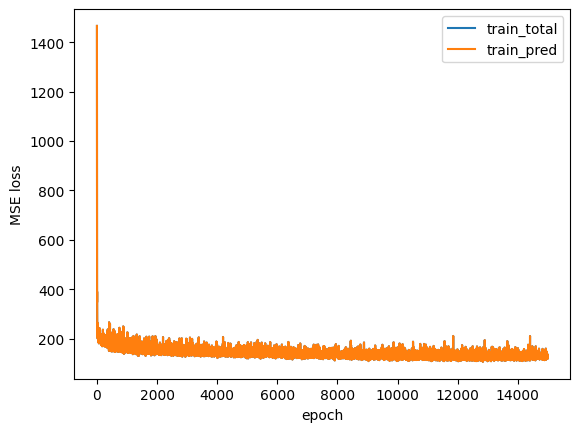

In [30]:
plt.plot(list(range(1, epoch+1)), total_loss_train_history, label='train_total')
plt.plot(list(range(1, epoch+1)), pred_loss_train_history, label='train_pred')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend()
# plt.savefig('loss_plot.png')
# plt.close()



After training, to make predictions, we can load the best model and run it on the (test) dataset.

In [31]:
def make_prediction(dataLoader, device=torch.device("cpu"), folder="train/"):
    ck = folder + "best_checkpoint.pth"
    # load the best model
    model, t = load_model(ck, device)
    T = torch.tensor(t).to(device)
    t = np.array(t)

    loss_test  = []
    y_pred = []
    oy=[]

    with torch.no_grad():
        model.eval()
        """
        Get the performance of the best train model on test dataset
        """
        for x, y in dataLoader.get_test_batch():
            x, y = x.to(device), y.to(device)
            test_y = model.forward(x)
            print(test_y)
            oy.extend(y.cpu().numpy().tolist())
            y_pred.extend(test_y.detach().cpu().numpy().tolist())
            test_loss = compute_loss(test_y, y)
            loss_test.append(test_loss.item())
    """
    Compute the MSE of the test dataset
    """
    timestamp = np.array([i for i in range(len(oy))])
    #y = dataLoader.Y_standardizer.inverse_transform(oy)
    #test_y = dataLoader.Y_standardizer.inverse_transform(y_pred)
    print(oy)
    print(y_pred)
    plt.figure(figsize=(10, 6))
    plt.plot(timestamp, oy, label='Actual Labels (y)', color='blue', linestyle='-')
    plt.xlabel('Timestamp')
    plt.ylabel('Actual Labels (y)')
    # Create a line plot for test_y
    plt.plot(timestamp, y_pred, label='Predicted Labels (test_y)', color='red', linestyle='--')
    plt.ylabel('Predicted Labels (test_y)')
    # Add a legend
    plt.legend()
    # Set the title
    plt.title('Actual vs. Predicted Labels Over Time')
    # Display the grid
    plt.grid(True)
    # Show the plot
    plt.show()


    print("test accuracy MSE :", np.mean(loss_test))

    """
    return the predicted y values by re-scaling the model output
    """

    #return dataLoader.Y_standardizer.inverse_transform(y_pred)
    return y_pred


In [32]:
for x, y in dataLoader.get_test_batch():
        x, y = x.to(device), y.to(device)
        test_y = model.forward(x)
        print(test_y)

tensor([[1419.7504],
        [1680.3890],
        [1611.5112],
        [1677.8607],
        [1601.5975],
        [1642.5554],
        [1633.3763],
        [1653.4883],
        [1529.7699],
        [1835.7166],
        [1707.9901],
        [1879.8109],
        [1664.5620],
        [1781.7424],
        [1620.7157],
        [1424.6268],
        [1486.4806],
        [1537.1727],
        [1352.8125],
        [1338.5039],
        [1445.6910],
        [1339.9142],
        [1315.2069],
        [1337.9286],
        [1330.6073],
        [1416.0992],
        [1367.2880],
        [1362.8051],
        [1487.0701],
        [1338.3439],
        [1434.4789],
        [1367.5032],
        [1377.2157],
        [1324.1207],
        [1326.4583],
        [1452.6964],
        [1312.2062],
        [1324.4199],
        [1433.3634],
        [1288.7882],
        [1249.5326],
        [1414.9369],
        [1224.1776],
        [1288.9176],
        [1368.0614],
        [1282.9528],
        [1303.5096],
        [1378

tensor([[1678.5436],
        [1626.2325],
        [1611.1241],
        [1626.6566],
        [1689.3184],
        [1590.4633],
        [1541.0923],
        [1580.3040],
        [1596.1727],
        [1883.7006],
        [1789.2975],
        [1884.9291],
        [1900.8909],
        [1755.1451],
        [1630.7836],
        [1742.7029],
        [1510.4039],
        [1530.2169],
        [1413.7457],
        [1280.0690],
        [1352.3706],
        [1244.6420],
        [1333.4669],
        [1387.2316],
        [1527.0863],
        [1409.4901],
        [1357.8588],
        [1448.8073],
        [1283.3074],
        [1375.6595],
        [1246.9036],
        [1363.7159],
        [1277.7260],
        [1376.2369],
        [1416.1112],
        [1478.5895],
        [1412.4653],
        [1376.7759],
        [1415.5585],
        [1495.6112],
        [1425.8453],
        [1393.2599],
        [1309.6797],
        [1422.5276],
        [1395.2677],
        [1393.1952],
        [1389.9240],
        [1508

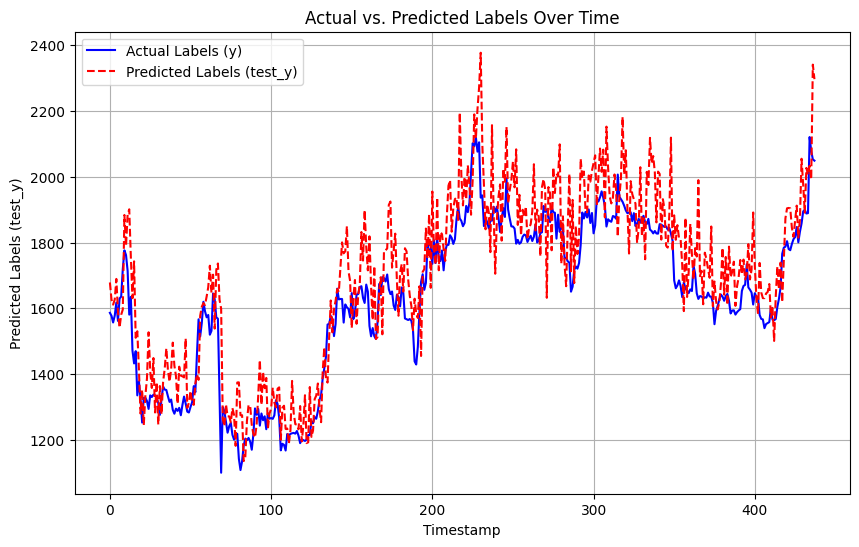

test accuracy MSE : 124.50057260159488
test accuracy MAPE : 4.942207038402557


In [33]:
loss_test  = []
y_pred = []
oy=[]
loss_mape  = []
from ignite.contrib.metrics.regression import *
from ignite.engine import *
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)
metric = MedianAbsolutePercentageError()
metric.attach(default_evaluator, 'mape')
for x, y in dataLoader.get_test_batch():
            x, y = x.to(device), y.to(device)
            test_y = model.forward(x)
            print(test_y)
            oy.extend(y.cpu().numpy().tolist())
            y_pred.extend(test_y.detach().cpu().numpy().tolist())
            test_loss = compute_loss(test_y, y)
            state = default_evaluator.run([[test_y, y]])
            loss_mape.append(state.metrics['mape'])
            loss_test.append(test_loss.item())
timestamp = np.array([i for i in range(len(oy))])
print(oy)
print(y_pred)
plt.figure(figsize=(10, 6))
plt.plot(timestamp, oy, label='Actual Labels (y)', color='blue', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Actual Labels (y)')
# Create a line plot for test_y
plt.plot(timestamp, y_pred, label='Predicted Labels (test_y)', color='red', linestyle='--')
plt.ylabel('Predicted Labels (test_y)')
# Add a legend
plt.legend()
# Set the title
plt.title('Actual vs. Predicted Labels Over Time')
# Display the grid
plt.grid(True)
# Show the plot
plt.show()


print("test accuracy MSE :", math.sqrt(np.mean(loss_test)))
print("test accuracy MAPE :", np.mean(loss_mape))

tensor([[1561.5944],
        [1711.5477],
        [1520.8239],
        [1613.6429],
        [1533.6464],
        [1624.1028],
        [1667.6058],
        [1697.4137],
        [1663.7263],
        [1816.3723],
        [1771.2777],
        [1796.3949],
        [1658.8763],
        [1824.7781],
        [1533.4366],
        [1598.3119],
        [1329.9445],
        [1497.7516],
        [1366.0936],
        [1477.6539],
        [1314.6012],
        [1299.6705],
        [1408.5918],
        [1362.4156],
        [1348.8002],
        [1337.1849],
        [1353.8971],
        [1263.2598],
        [1340.9880],
        [1343.5109],
        [1262.8378],
        [1347.4095],
        [1438.4417],
        [1342.3669],
        [1299.4557],
        [1325.9745],
        [1316.8922],
        [1367.7789],
        [1448.3121],
        [1424.4279],
        [1352.8317],
        [1196.2332],
        [1277.7357],
        [1436.1722],
        [1148.1013],
        [1306.2628],
        [1333.3956],
        [1322

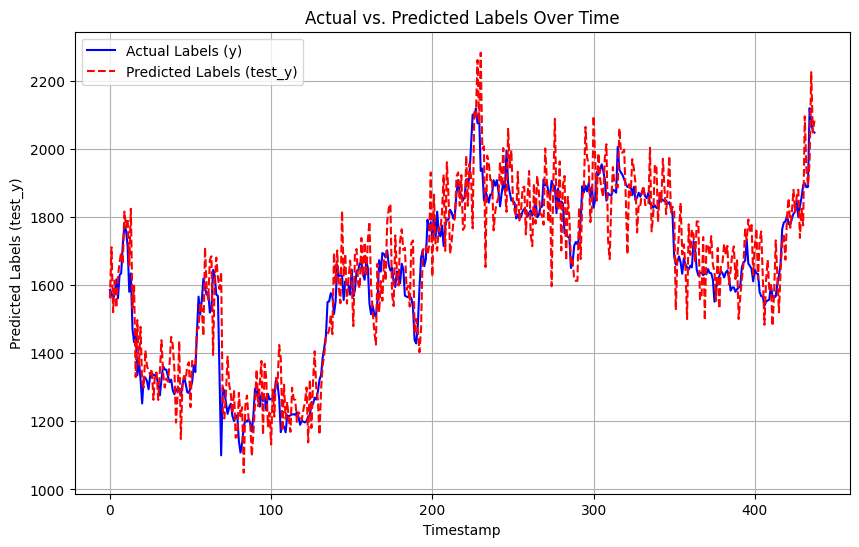

test accuracy MSE : 98.88086167043399


In [34]:
loss_test  = []
y_pred = []
oy=[]
for x, y in dataLoader.get_test_batch():
            x, y = x.to(device), y.to(device)
            test_y = model.forward(x)
            print(test_y)
            oy.extend(y.cpu().numpy().tolist())
            y_pred.extend(test_y.detach().cpu().numpy().tolist())
            test_loss = compute_loss(test_y, y)
            loss_test.append(test_loss.item())
timestamp = np.array([i for i in range(len(oy))])
print(oy)
print(y_pred)
plt.figure(figsize=(10, 6))
plt.plot(timestamp, oy, label='Actual Labels (y)', color='blue', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Actual Labels (y)')
# Create a line plot for test_y
plt.plot(timestamp, y_pred, label='Predicted Labels (test_y)', color='red', linestyle='--')
plt.ylabel('Predicted Labels (test_y)')
# Add a legend
plt.legend()
# Set the title
plt.title('Actual vs. Predicted Labels Over Time')
# Display the grid
plt.grid(True)
# Show the plot
plt.show()


print("test accuracy MSE :", math.sqrt(np.mean(loss_test)))

In [35]:
y_pred = make_prediction(dataLoader)

AssertionError: 

In [ ]:
y_pred

We can plot the learned bases.

In [ ]:
def plot_bases( device=torch.device("cpu"), folder="train/"):
    ck = folder + "best_checkpoint.pth"
    model, t = load_model(ck, device)
    T = torch.tensor(t).to(device)
    t = np.array(t)

    bases = []

    loss_test  = []

    with torch.no_grad():
        model.eval()

        for i, basis in enumerate(model.BL):
            T = T.unsqueeze(dim=-1)
            y = np.squeeze(basis(T).squeeze(dim=-1).detach().cpu().numpy())
            y_sq = y ** 2
            l2_norm = np.sqrt(np.sum((y_sq[:-1] + y_sq[1:]) * (t[1:] - t[:-1])) / 2)
            bases.append(y / l2_norm)

    B = len(bases)
    fig, axs = plt.subplots(1, B)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for i in range(B):
        axs[i].plot(t, bases[i], linewidth=3.5, label="basis"+str(i+1))
        axs[i].legend()

    return bases


In [ ]:
bases = plot_bases()

Even when both measurement error and noise were present, using roughly 60% of the dataset, the model successfully captured the important features of the true signal $\phi_5$.

To better understand the learned bases, we can also plot a linear combination of them and see what it looks compared to the true one.

In [ ]:
def plot(t, y, color, label):
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.plot(t, y, linewidth=3.5, color=color, label=label)
    plt.legend()

The coefficients of learned bases can vary in different experiments (see Theorem 1 and Remark 1 in the paper).

In [ ]:
np_b = [np.array(b) for b in bases]
lin = np_b[0] + 0.4 * np_b[1]
plot(grid, lin, "orangered", "learned basis1 + 0.4 * basis2")

The true signal $\phi_5$ in Case 3 is drawn below. We can see that two bases learned the truth successfully.

In [ ]:

phi5 = _phi(5)
plot(grid, phi5(np.array(grid)), "green", "true phi5")